In [1]:
%load_ext autoreload
%autoreload 2 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from tqdm import tqdm_notebook as tqdm
import skimage
import cv2

from nionswift_plugin.nionswift_structure_recognition.test.sample import graphene_in_a_box, gaussian_superposition
from nionswift_plugin.nionswift_structure_recognition.scale import rollout_image, create_template
#from nionswift_plugin.nionswift_structure_recognition.nms import non_maximum_suppresion
from nionswift_plugin.nionswift_structure_recognition.utils import ind2sub

0.048828125
0.05201226790306931
6.521124665485941 0.048828125 0.05201226790306931


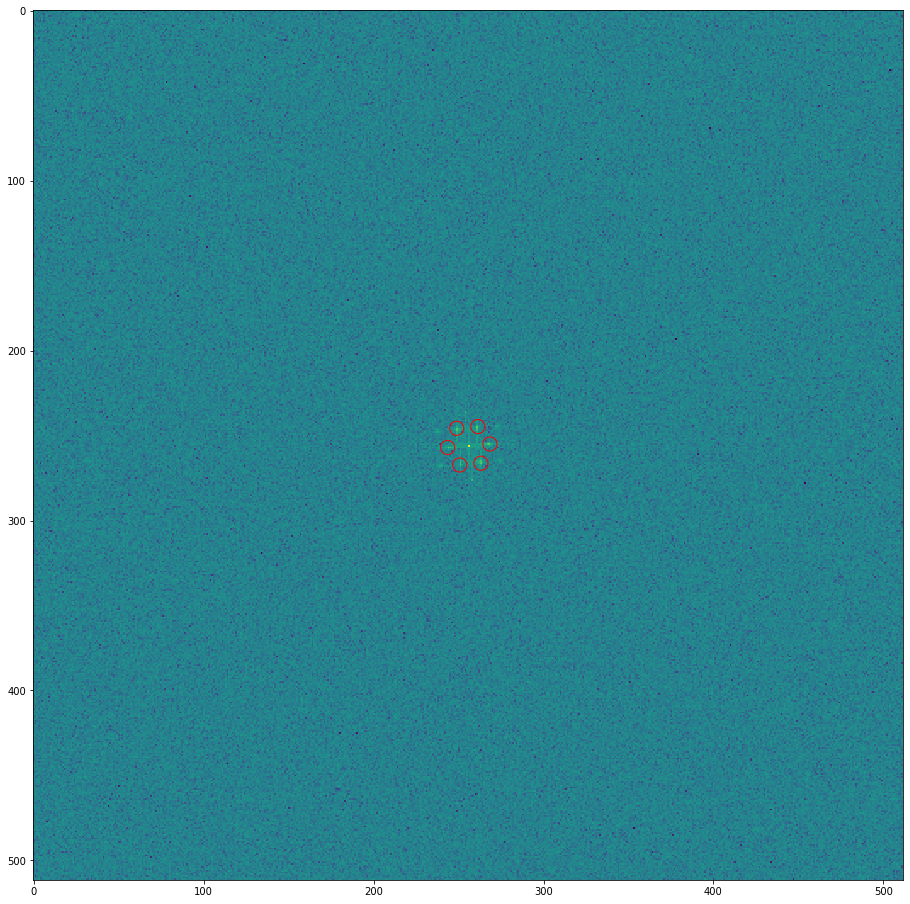

In [17]:
size = (25,25)
shape = (512,512)

positions, cell = graphene_in_a_box(size, rotation=np.random.rand() * 360., a=2.46)
image = gaussian_superposition(positions, shape, (0,0), size, .5)
image = np.random.poisson(1 + image)
nbins_angular = 64
inner = 1

peaks = np.linspace(0, 1, 6,endpoint=False)
template = create_template(peaks, [1.]*6, nbins_angular, 1)

#template = np.roll(template, 5, 0)

n = image.shape[0]

F = np.fft.fftshift(np.abs(np.fft.fft2(image)) ** 2)

unrolled = rollout_image(F, inner, n // 2, nbins_angular=nbins_angular)
unrolled /= unrolled.max()

unrolled = np.pad(unrolled, [(unrolled.shape[0] // 2, unrolled.shape[0] // 2), (0,0)], mode='wrap').astype(np.float32)
h = cv2.matchTemplate(unrolled, template.astype(np.float32), method=2)

rows, cols = ind2sub(h.shape,h.argmax())

angle = (rows + .5) / nbins_angular * 2 * np.pi
angles = np.linspace(0, 2 * np.pi, 6, endpoint=False) + angle
radial = cols + inner + 1.5

x = np.cos(angles) * radial
y = np.sin(angles) * radial

points = np.array([y,x]).T  + np.array(F.shape) / 2

print(size[0]/shape[0])

d = 2.46
c = np.sqrt(3) / 2

true = size[0]/shape[0]
measured = (radial) * d / float(n) * c

print(measured)

error = (measured - true) / true

print(error * 100, true, measured)
plt.figure(figsize=(16,16))
plt.scatter(points[:,1],points[:,0], facecolors='none', edgecolors='r', s=200)
plt.imshow(np.log(1+F))
#x,y

#plt.figure(figsize=(24,24))
#plt.imshow(h)
#plt.colorbar()
#plt.plot(*peaks.T, 'ro')

In [57]:
2.5 / 256 * 10

0.09765625

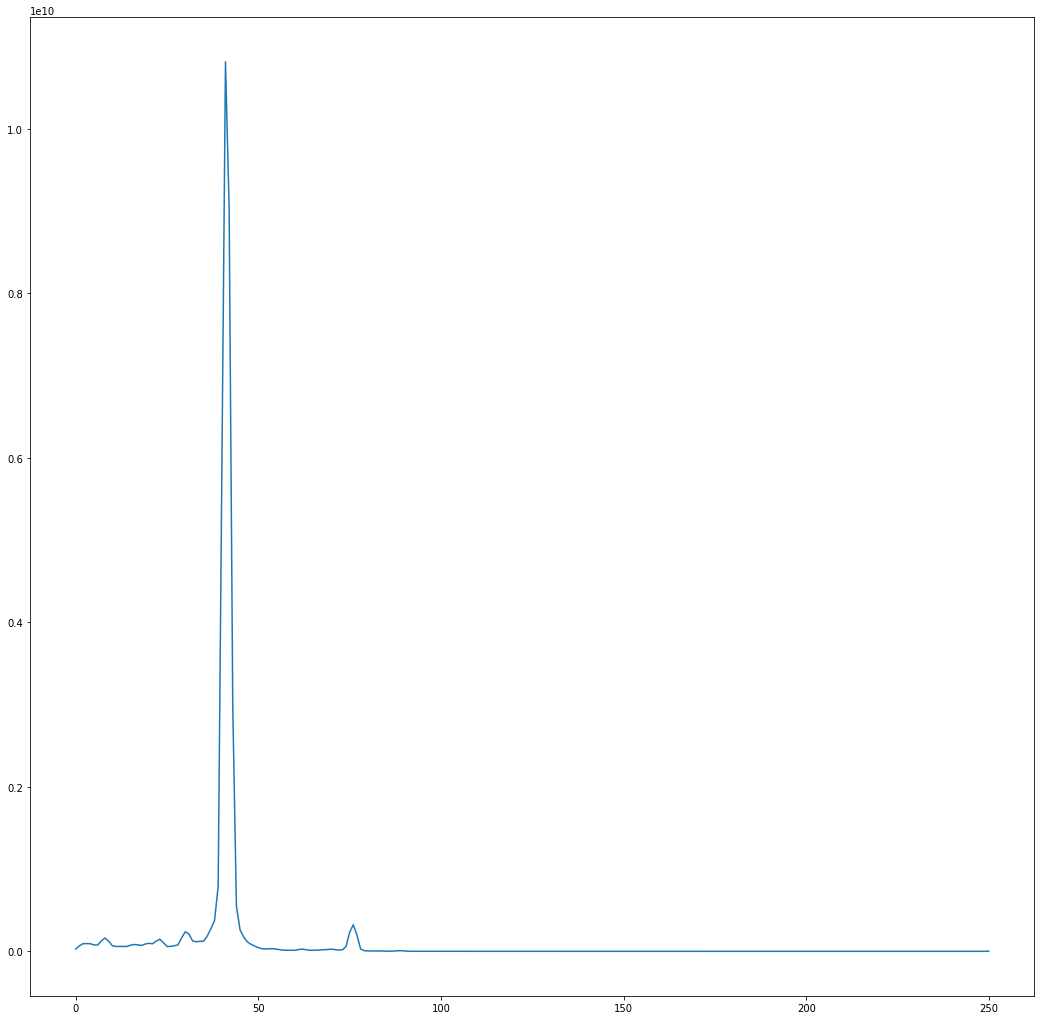

In [287]:
#for i in tqdm(range(1000)):
from skimage.feature import match_template

#convolved = correlate2d(unrolled, template, mode='same', boundary='wrap') #/ unrolled.sum(axis=0)
#convolved = convolve2d(unrolled, template, mode='same', boundary='wrap') #/ unrolled.sum(axis=0)
#convolved = match_template(unrolled, template, mode='wrap', pad_input=True)




#plt.figure(figsize=(18,18))
#plt.imshow(convolved)
#plt.imshow(unrolled)
#plt.plot((convolved).sum(axis=0))